In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from matplotlib import pyplot as plt
import seaborn as sns


In [ ]:
# Load the dataset
EDdata3 = pd.read_csv('/content/drive/MyDrive/AI_SE/SelctedDataFilter2New_MergAmb.csv')

<ipython-input-3-eec88c0522ac>:2: DtypeWarning: Columns (31,33,35,37,39,41) have mixed types. Specify dtype option on import or set low_memory=False.
  EDdata3 = pd.read_csv('/content/drive/MyDrive/AI_SE/SelctedDataFilter2New_MergAmb.csv')


In [ ]:
print(EDdata3.columns)

Index(['Unnamed: 0', 'EDArrivalDate', 'Shift', 'Month', 'Arrival Day',
       'Arrival Hour', 'Arrival_Hr_Rd', 'Arrival Shift (1st:11 PM)',
       'Arrival Shift (1st: 12 AM)', 'Bed_Date', 'FirstProviderSignUpDate',
       'First provider in hours', 'Waiting for First provider',
       'Waiting for 1st provider_Rd2', 'Waiting for 1st provider_Rd',
       'EDOUBedDate', 'PhysicalDepartDate', 'LOS', 'LOS rounded ', 'LOS_OBS',
       'ESILevel', 'Gender', 'CalcAgeInYears', 'Age Group', 'EDLevel',
       'PresentingComplaint', 'FinalDiagnosis', 'Pat_OrderCount_Total',
       'BehavioralHealth', 'DispoType', 'TransportArrive', 'PatientsPerMD_Max',
       'PatientsPerMD_Mean', 'PatientsPerMD_Mean_Rd', 'PatientsPerMD_Med',
       'PatientsPerNURSE_Max', 'PatientsPerNURSE_Mean',
       'PatientsPerNURSE_Mean_Rd', 'PatientsPerNURSE_Med',
       'PatientsPerPA_RESIDENT_Max', 'PatientsPerPA_RESIDENT_Mean',
       'PatientsPerPA_RESIDENT_Mean_Rd', 'PatientsPerPA_RESIDENT_Med',
       'FirstWard', 

In [ ]:
# Selecting specific columns for the analysis
selected_columns = [ 'LOS rounded ', 'Arrival Shift (1st: 12 AM)','FinalDiagnosis' ,'ESILevel', 'Gender', 'Age Group', 'EDLevel', 'DispoType', 'TransportArrive', 'PatientsPerMD_Mean_Rd', 'PatientsPerNURSE_Mean_Rd', 'PatientsPerPA_RESIDENT_Mean_Rd', 'Ward Change']
EDdatanoNorthTrans = EDdata3[selected_columns]

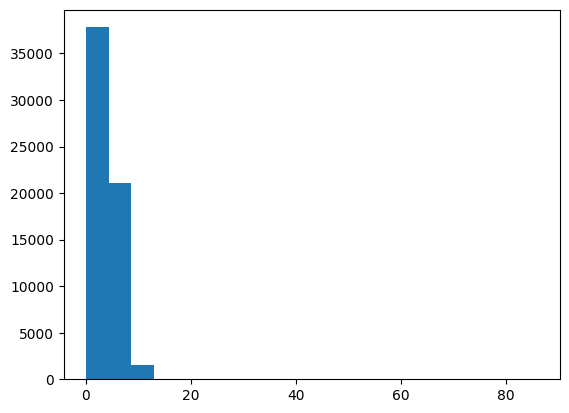

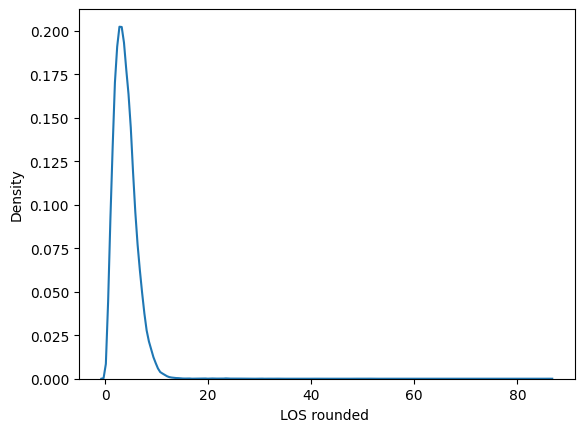

In [ ]:
# Check LOS
plt.hist(EDdatanoNorthTrans['LOS rounded '], bins=20)
plt.show()
sns.kdeplot(EDdatanoNorthTrans['LOS rounded '])
plt.show()


In [ ]:
# Filter the dataset for LOS less than 24 hours and drop NA values
EDdataBelow24_No_NorthTrans = EDdatanoNorthTrans[EDdatanoNorthTrans['LOS rounded '] < 24].dropna()

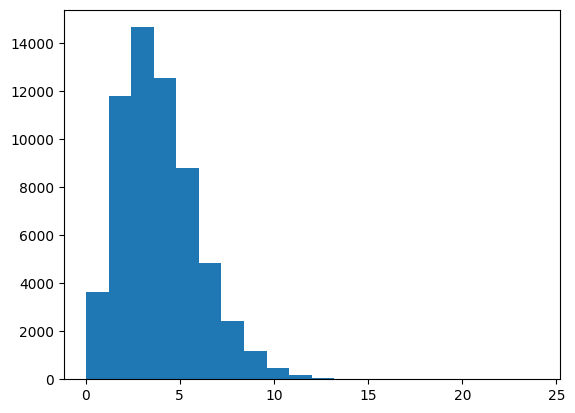

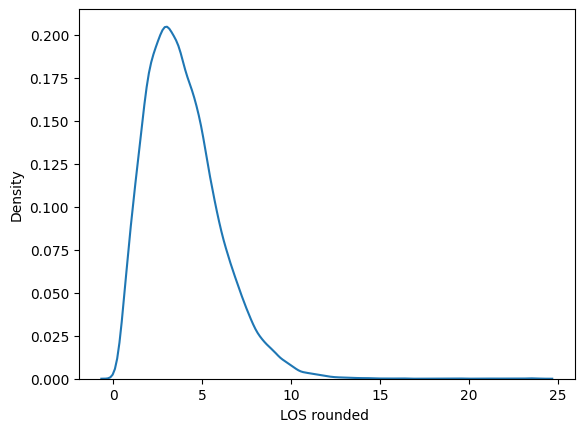

In [ ]:
# Histogram after filtering
plt.hist(EDdataBelow24_No_NorthTrans['LOS rounded '], bins=20)
plt.show()
sns.kdeplot(EDdataBelow24_No_NorthTrans['LOS rounded '])
plt.show()

In [ ]:
# Remove certain diagnoses
diagnoses_to_remove = ["Suicidal ideation", "Depression", "Psychosis"]
EDdataBelow24_No_NorthTrans_NoMental = EDdataBelow24_No_NorthTrans[~EDdataBelow24_No_NorthTrans['FinalDiagnosis'].isin(diagnoses_to_remove)]

In [ ]:
# Remove the 'FinalDiagnosis' column
EDdataBelow24_No_NorthTrans_NoMental = EDdataBelow24_No_NorthTrans_NoMental.drop('FinalDiagnosis', axis=1)

# Check the remaining columns
print(EDdataBelow24_No_NorthTrans_NoMental.columns)

Index(['LOS rounded ', 'Arrival Shift (1st: 12 AM)', 'ESILevel', 'Gender',
       'Age Group', 'EDLevel', 'DispoType', 'TransportArrive',
       'PatientsPerMD_Mean_Rd', 'PatientsPerNURSE_Mean_Rd',
       'PatientsPerPA_RESIDENT_Mean_Rd', 'Ward Change'],
      dtype='object')


In [ ]:
print(EDdataBelow24_No_NorthTrans_NoMental.dtypes)


LOS rounded                       float64
Arrival Shift (1st: 12 AM)         object
ESILevel                           object
Gender                             object
Age Group                          object
EDLevel                            object
DispoType                          object
TransportArrive                    object
PatientsPerMD_Mean_Rd              object
PatientsPerNURSE_Mean_Rd           object
PatientsPerPA_RESIDENT_Mean_Rd     object
Ward Change                        object
dtype: object


In [ ]:
# Convert the numerical  columns to float64
EDdataBelow24_No_NorthTrans_NoMental['PatientsPerMD_Mean_Rd'] = pd.to_numeric(EDdataBelow24_No_NorthTrans_NoMental['PatientsPerMD_Mean_Rd'], errors='coerce')
EDdataBelow24_No_NorthTrans_NoMental['PatientsPerNURSE_Mean_Rd'] = pd.to_numeric(EDdataBelow24_No_NorthTrans_NoMental['PatientsPerNURSE_Mean_Rd'], errors='coerce')
EDdataBelow24_No_NorthTrans_NoMental['PatientsPerPA_RESIDENT_Mean_Rd'] = pd.to_numeric(EDdataBelow24_No_NorthTrans_NoMental['PatientsPerPA_RESIDENT_Mean_Rd'], errors='coerce')

# Check the data types again
print(EDdataBelow24_No_NorthTrans_NoMental.dtypes)

LOS rounded                       float64
Arrival Shift (1st: 12 AM)         object
ESILevel                           object
Gender                             object
Age Group                          object
EDLevel                            object
DispoType                          object
TransportArrive                    object
PatientsPerMD_Mean_Rd             float64
PatientsPerNURSE_Mean_Rd          float64
PatientsPerPA_RESIDENT_Mean_Rd    float64
Ward Change                        object
dtype: object


In [ ]:
# Apply one-hot encoding to the categorical columns
EDdata_encoded = pd.get_dummies(EDdataBelow24_No_NorthTrans_NoMental)


In [ ]:
# Splitting the data into features and target variable
X = EDdata_encoded.drop('LOS rounded ', axis=1)
y = EDdata_encoded['LOS rounded ']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)


In [ ]:
# Drop rows with NaN values in the training and testing data
X_train_dropped = X_train.dropna()
y_train_dropped = y_train[X_train_dropped.index]

X_test_dropped = X_test.dropna()
y_test_dropped = y_test[X_test_dropped.index]

In [ ]:
# Fit the model on the data with dropped NaN values
rf_model = RandomForestRegressor(n_estimators=100, random_state=1234)
rf_model.fit(X_train_dropped, y_train_dropped)

# Make predictions on the test data
rf_predictions = rf_model.predict(X_test_dropped)

In [ ]:
# Evaluate models' performance
rf_mse = mean_squared_error(y_test_dropped, rf_predictions)
print(f'Random Forest MSE: {rf_mse}')

Random Forest MSE: 2.599186102223308


In [ ]:
from sklearn.metrics import r2_score

# Calculate R^2 score
rf_r2 = r2_score(y_test, rf_predictions)

# Display the R^2 score
print(f"Random Forest R^2 Score: {rf_r2}")


Random Forest R^2 Score: 0.3713172079531064


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

# Random Forest Model
rf2 = RandomForestRegressor(random_state=1234)

# Parameters for tuning
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in random forest
    'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split
    'max_depth': [10, 20, 30, None],  # Maximum number of levels in tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
}


In [ ]:
# Grid search with cross-validation
grid_search = GridSearchCV(estimator=rf2, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train_dropped, y_train_dropped)

# Best parameters found
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the model with the best parameters
best_rf_model = grid_search.best_estimator_

# Make predictions with the best model
rf_predictions2 = best_rf_model.predict(X_test_dropped)


Fitting 3 folds for each of 216 candidates, totalling 648 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best parameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


In [24]:
# Evaluate the model
rf_mse2 = mean_squared_error(y_test_dropped, rf_predictions2)
print(f"Random Forest Mean Squared Error: {rf_mse2}")

# Calculate R^2 score
rf2_r2 = r2_score(y_test_dropped, rf_predictions2)

# Display the R^2 score
print(f"Random Forest R^2 Score: {rf2_r2}")


Random Forest Mean Squared Error: 2.5396401410527494
Random Forest R^2 Score: 0.38571999392206824


In [ ]:
# Function to clean column names
def clean_column_names(df):
    df.columns = [col.replace('[', '').replace(']', '').replace('<', '') for col in df.columns]
    return df

# Clean the column names for both training and test sets
X_train_cleaned = clean_column_names(X_train_dropped)
X_test_cleaned = clean_column_names(X_test_dropped)

# Fitting the XGBoost model again
xgb_model = XGBRegressor(n_estimators=100, random_state=1234)
xgb_model.fit(X_train_cleaned, y_train_dropped)
xgb_predictions = xgb_model.predict(X_test_cleaned)

In [ ]:
#evaluatew model perfmance
# Calculate R-squared (R²)
r2 = r2_score(y_test_dropped, xgb_predictions)
print(f"R-squared (R²) for XGBoost Model: {r2}")

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_dropped, xgb_predictions)
print(f"Mean Squared Error (MSE) for XGBoost Model: {mse}")

R-squared (R²) for XGBoost Model: 0.3946321863575265
Mean Squared Error (MSE) for XGBoost Model: 2.5027941401575076


In [ ]:
from sklearn.preprocessing import StandardScaler


# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_cleaned)
X_test_scaled = scaler.transform(X_test_cleaned)



In [ ]:
# Create a neural network model
.
nn_model = MLPRegressor(hidden_layer_sizes=(100,),  # One hidden layer with 100 neurons
                        activation='relu',         # 'relu' is a common activation function
                        random_state=1234,
                        max_iter=500)              # Maximum number of iterations



In [ ]:
# Fit the model
nn_model.fit(X_train_scaled, y_train_dropped)



MLPRegressor(max_iter=500, random_state=1234)

In [ ]:
# Predict LOS
nn_predictions = nn_model.predict(X_test_scaled)

# Evaluate the model
nn_mse = mean_squared_error(y_test_dropped, nn_predictions)
nn_r2 = r2_score(y_test_dropped, nn_predictions)

print(f"Neural Network Mean Squared Error (MSE): {nn_mse}")
print(f"Neural Network R-squared (R²): {nn_r2}")

Neural Network Mean Squared Error (MSE): 2.5684654387808155
Neural Network R-squared (R²): 0.37874782342540303


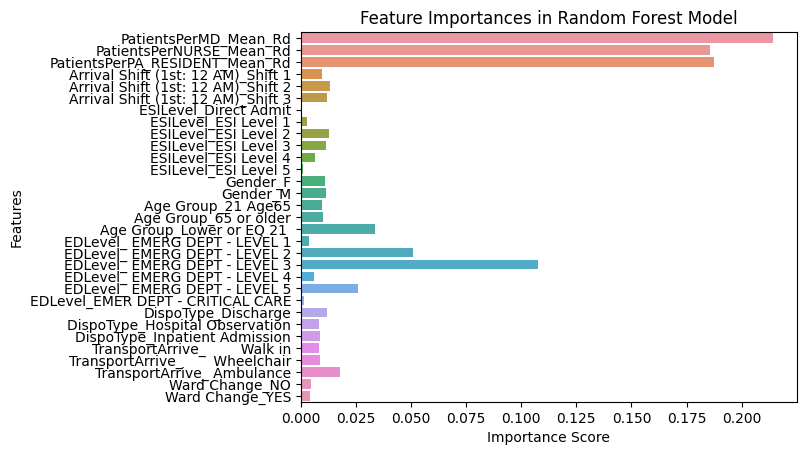

In [ ]:
# Feature importance
import matplotlib.pyplot as plt
import seaborn as sns

# Random Forest model
feature_importances_rf = rf_model.feature_importances_
features = X_train_cleaned.columns  # Assuming X_train_cleaned is your feature set

# Create a pandas series for visualization
importances_rf = pd.Series(feature_importances_rf, index=features)

# Plot
sns.barplot(x=importances_rf, y=importances_rf.index)
plt.title('Feature Importances in Random Forest Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


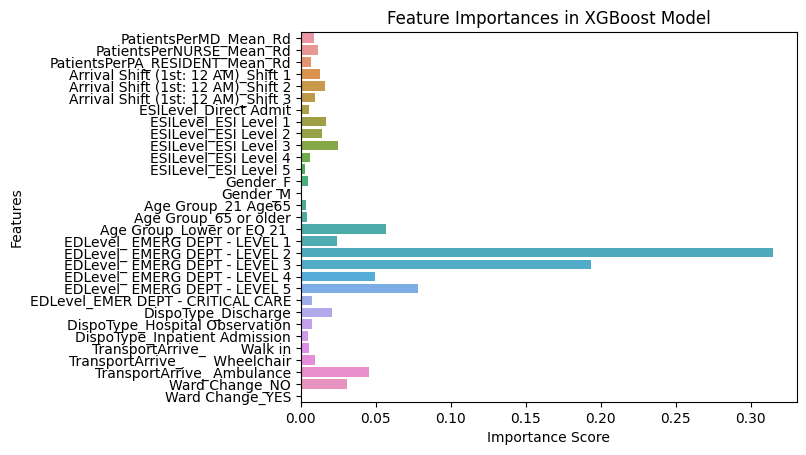

In [ ]:
# XGBoost model
feature_importances_xgb = xgb_model.feature_importances_

# Create a pandas series for visualization
importances_xgb = pd.Series(feature_importances_xgb, index=features)

# Plot
sns.barplot(x=importances_xgb, y=importances_xgb.index)
plt.title('Feature Importances in XGBoost Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


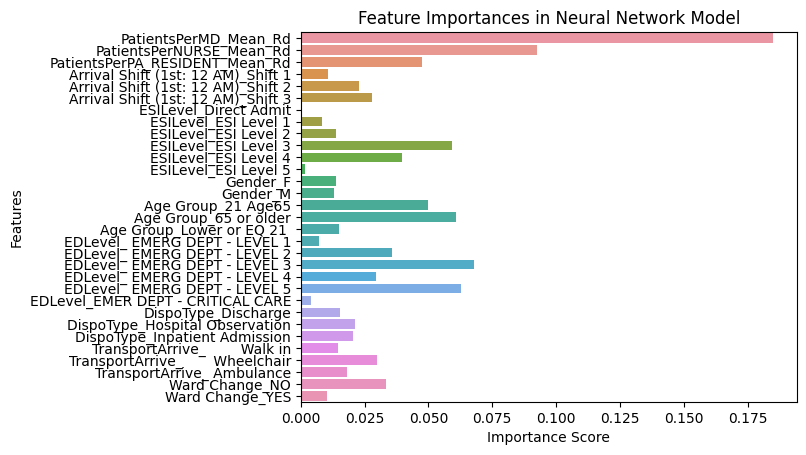

In [ ]:
from sklearn.inspection import permutation_importance

# Perform permutation importance
perm_importance = permutation_importance(nn_model, X_test_scaled, y_test_dropped, n_repeats=10, random_state=1234)

# Create a pandas series for visualization
importances_nn = pd.Series(perm_importance.importances_mean, index=features)

# Plot
sns.barplot(x=importances_nn, y=importances_nn.index)
plt.title('Feature Importances in Neural Network Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()
